# *Step-1:* Business Problem Understanding
- Whether a review is original or computer generated.

# *Step-2:*  Data Understanding

**2.1 Import Necessary Libraries**

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
import string
import seaborn as sns
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import StackingClassifier
import pickle
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import accuracy_score,precision_score

In [2]:
df = pd.read_csv('fake reviews dataset.csv')

df.head()

,category,rating,label,text_
0,Home_and_Kitchen_5,5.0,CG,"Love this! Well made, sturdy, and very comfor..."
1,Home_and_Kitchen_5,5.0,CG,"love it, a great upgrade from the original. I..."
2,Home_and_Kitchen_5,5.0,CG,This pillow saved my back. I love the look and...
3,Home_and_Kitchen_5,1.0,CG,"Missing information on how to use it, but it i..."
4,Home_and_Kitchen_5,5.0,CG,Very nice set. Good quality. We have had the s...


In [3]:
df.drop(columns = {'category'}, inplace = True)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40432 entries, 0 to 40431
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   rating  40432 non-null  float64
 1   label   40432 non-null  object 
 2   text_   40432 non-null  object 
dtypes: float64(1), object(2)
memory usage: 947.8+ KB


In [5]:
df.rename(columns = {'text_': 'text'}, inplace = True)

In [6]:
df.head()

,rating,label,text
0,5.0,CG,"Love this! Well made, sturdy, and very comfor..."
1,5.0,CG,"love it, a great upgrade from the original. I..."
2,5.0,CG,This pillow saved my back. I love the look and...
3,1.0,CG,"Missing information on how to use it, but it i..."
4,5.0,CG,Very nice set. Good quality. We have had the s...


In [7]:
def encode_label(df):
    labels = {
        'CG': 0,
        'OR': 1
    }
    
    df['target'] = df['label'].map(labels)
    
    return df

In [8]:
df = encode_label(df)
df['target'] = df['target'].fillna(0).replace([np.inf, -np.inf], 0)
df['target'] = df['target'].astype(int)
df.head()

,rating,label,text,target
0,5.0,CG,"Love this! Well made, sturdy, and very comfor...",0
1,5.0,CG,"love it, a great upgrade from the original. I...",0
2,5.0,CG,This pillow saved my back. I love the look and...,0
3,1.0,CG,"Missing information on how to use it, but it i...",0
4,5.0,CG,Very nice set. Good quality. We have had the s...,0


In [9]:
df.drop(columns = {'rating', 'label'}, inplace = True)

In [10]:
df = df.sample(frac=1).reset_index(drop=True)

df.sample(10)

,text,target
19919,What do people want from this book? This is a...,0
20309,"I thought it would be a little more expensive,...",0
5815,Ferrigno has a perfect summer read here. It ha...,1
30686,This company's dog toys are extremely well mad...,1
30919,Beautiful and sturdy shower rack. Good qualit...,1
33811,This book was in a word: adorable. Though perh...,1
8111,I love this show!! The only problem is having...,1
37064,Good sized mustache. It fits perfect on the ne...,0
12339,I saw this in the theatre when it was first re...,1
6034,"If I thought too much about it, I'd say I didn...",0


In [11]:
df.isnull().sum()

text      0
target    0
dtype: int64

In [12]:
df.duplicated().sum()

20

In [13]:
df.drop_duplicates(inplace = True)

In [14]:
df.duplicated().sum()

0

In [15]:
df['target'].value_counts()

target
1    20215
0    20197
Name: count, dtype: int64

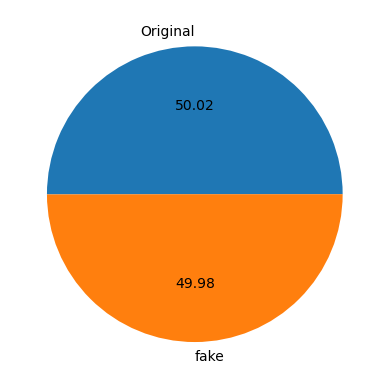

In [16]:
plt.pie(df['target'].value_counts(), labels=['Original', 'fake'],autopct="%0.2f")
plt.show()

# *Step-3:* Data Preprocessing

In [17]:
df['num_characters'] = df['text'].apply(len)
df['num_words'] = df['text'].apply(lambda x:len(nltk.word_tokenize(x)))
df['num_sentences'] = df['text'].apply(lambda x:len(nltk.sent_tokenize(x)))

In [18]:
df.head()

,text,target,num_characters,num_words,num_sentences
0,I gave it five stars because it kept me engage...,0,96,22,2
1,"Another plot of redemption from the beginning,...",0,303,63,5
2,I was really into this book. The characters we...,0,804,174,15
3,There is not a book Lindsay Buroker has writte...,1,698,143,6
4,Got this for my grandsons wedding. The quality...,0,79,18,2


In [19]:
df.describe()

,target,num_characters,num_words,num_sentences
count,40412.000000,40412.000000,40412.000000,40412.000000
mean,0.500223,351.365337,76.691131,5.277071
std,0.500006,369.871842,79.242859,4.915033
min,0.000000,24.000000,2.000000,1.000000
25%,0.000000,107.000000,24.000000,2.000000
50%,1.000000,198.000000,44.000000,3.000000
75%,1.000000,439.000000,96.000000,6.000000
max,1.000000,2827.000000,510.000000,133.000000


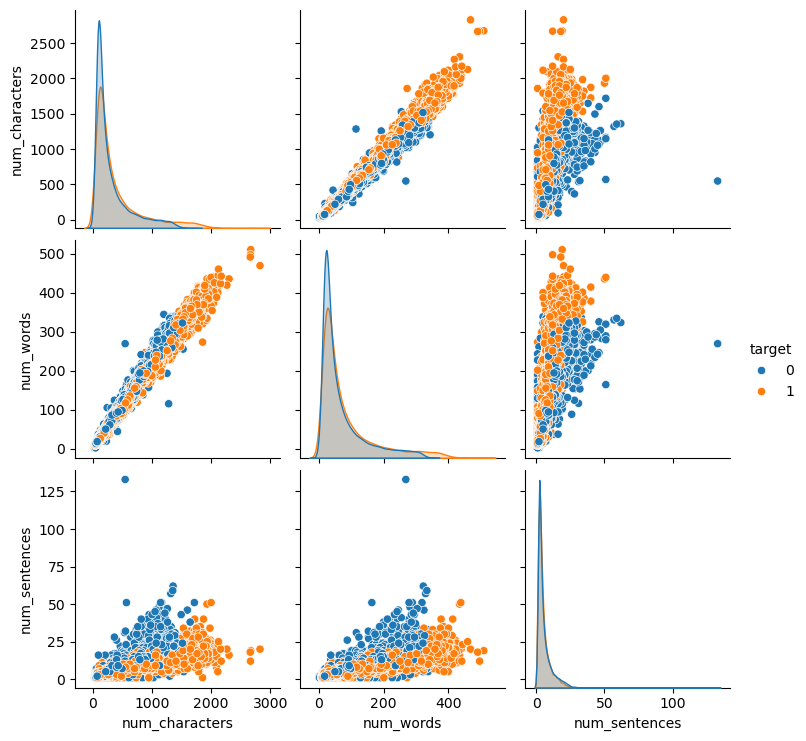

In [20]:
sns.pairplot(df,hue='target')
plt.show()

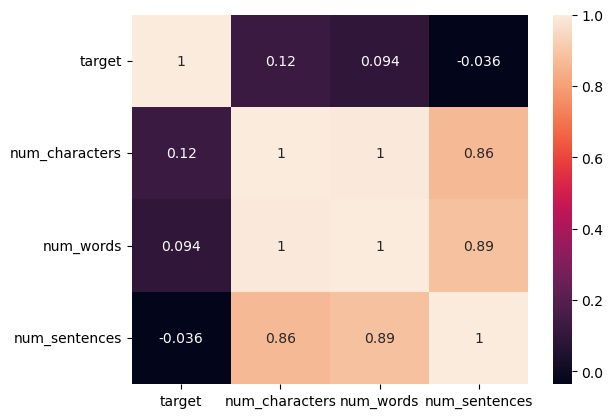

In [21]:
df_numeric = df.select_dtypes(include = 'number')
sns.heatmap(df_numeric.corr(),annot=True)
plt.show()

In [22]:
ps = PorterStemmer()

In [23]:
def transform_text(text):
    text = text.lower()
    text = nltk.word_tokenize(text)
    
    y = []
    for i in text:
        if i.isalnum():
            y.append(i)
    
    text = y[:]
    y.clear()
    
    for i in text:
        if i not in stopwords.words('english') and i not in string.punctuation:
            y.append(i)
            
    text = y[:]
    y.clear()
    
    for i in text:
        y.append(ps.stem(i))
    
            
    return " ".join(y)

In [24]:
transform_text("I'm gonna be home soon and i don't want to talk about this stuff anymore tonight, k? I've cried enough today.")

'gon na home soon want talk stuff anymor tonight k cri enough today'

In [25]:
df['transformed_text'] = df['text'].apply(transform_text)

In [26]:
df.head()

,text,target,num_characters,num_words,num_sentences,transformed_text
0,I gave it five stars because it kept me engage...,0,96,22,2,gave five star kept engag also like written woman
1,"Another plot of redemption from the beginning,...",0,303,63,5,anoth plot redempt begin end seri first one st...
2,I was really into this book. The characters we...,0,804,174,15,realli book charact well develop kept interest...
3,There is not a book Lindsay Buroker has writte...,1,698,143,6,book lindsay burok written anyth less fantast ...
4,Got this for my grandsons wedding. The quality...,0,79,18,2,got grandson wed qualiti good fit son well


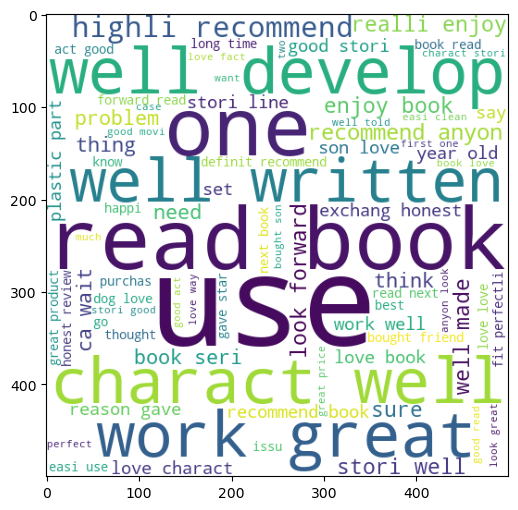

In [27]:
wc = WordCloud(width=500,height=500,min_font_size=10,background_color='white')
fake_wc = wc.generate(df[df['target'] == 0]['transformed_text'].str.cat(sep=" "))
plt.figure(figsize=(15,6))
plt.imshow(fake_wc)
plt.show()

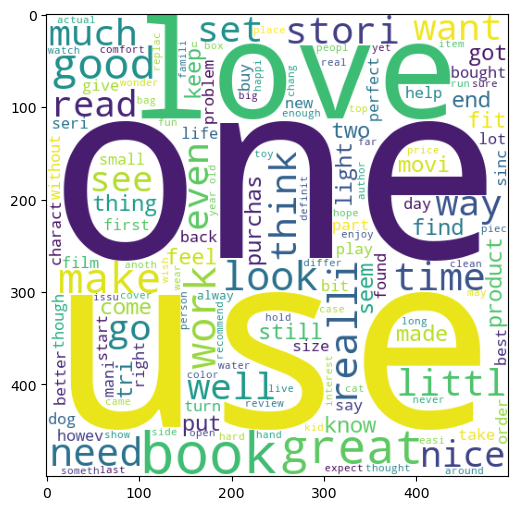

In [28]:
wc = WordCloud(width=500,height=500,min_font_size=10,background_color='white')
original_wc = wc.generate(df[df['target'] == 1]['transformed_text'].str.cat(sep=" "))
plt.figure(figsize=(15,6))
plt.imshow(original_wc)

In [29]:
tfidf = TfidfVectorizer(max_features=3000)
X = tfidf.fit_transform(df['transformed_text']).toarray()
y = df['target'].values

In [30]:
print(X.shape)
print(y.shape)

(40412, 3000)
(40412,)


# *Step-4:* Modelling 

In [31]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=32)

In [32]:
knc = KNeighborsClassifier()
mnb = MultinomialNB()
dtc = DecisionTreeClassifier(max_depth=5)
lrc = LogisticRegression(solver='liblinear', penalty='l1')
rfc = RandomForestClassifier(n_estimators=50, random_state=2)
abc = AdaBoostClassifier(n_estimators=50, random_state=2)
xgb = XGBClassifier(n_estimators=50,random_state=2)

In [33]:
clfs = {
    'KN' : knc, 
    'NB': mnb, 
    'DT': dtc, 
    'LR': lrc, 
    'RF': rfc, 
    'AdaBoost': abc, 
    'xgb':xgb
}

In [34]:
def train_classifier(clf,X_train,y_train,X_test,y_test):
    clf.fit(X_train,y_train)
    y_pred = clf.predict(X_test)
    accuracy = accuracy_score(y_test,y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    
    return accuracy,precision

In [35]:
accuracy_scores = []
precision_scores = []

for name,clf in clfs.items():    
    current_accuracy,current_precision = train_classifier(clf, X_train,y_train,X_test,y_test)
    
    accuracy_scores.append(current_accuracy)
    precision_scores.append(current_precision)

C:\Users\USER\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


In [36]:
performance_df = pd.DataFrame({'Algorithm':clfs.keys(),'Accuracy':accuracy_scores,'Precision':precision_scores}).sort_values('Precision',ascending=False)

In [37]:
performance_df.reset_index(drop = True)

,Algorithm,Accuracy,Precision
0,LR,0.852654,0.852655
1,NB,0.836818,0.838056
2,RF,0.833478,0.835475
3,xgb,0.816034,0.817149
4,AdaBoost,0.743041,0.743088
5,DT,0.615860,0.662315
6,KN,0.497588,0.544885


In [38]:
mnb = MultinomialNB()
lrc = LogisticRegression(solver='liblinear', penalty='l1')
rfc = RandomForestClassifier(n_estimators=50, random_state=2)

In [39]:
voting = VotingClassifier(estimators=[('LR', lrc), ('nb', mnb), ('RF', rfc)],voting='soft')

In [40]:
voting.fit(X_train,y_train)

VotingClassifier(estimators=[('LR',
                              LogisticRegression(penalty='l1',
                                                 solver='liblinear')),
                             ('nb', MultinomialNB()),
                             ('RF',
                              RandomForestClassifier(n_estimators=50,
                                                     random_state=2))],
                 voting='soft')

In [41]:
y_pred = voting.predict(X_test)
print("Accuracy",accuracy_score(y_test,y_pred))
print("Precision",precision_score(y_test,y_pred))

Accuracy 0.8639119138933564
Precision 0.8738783649052841


In [42]:
estimators = [('LR', lrc), ('nb', mnb), ('RF', rfc)]
final_estimator = RandomForestClassifier(n_estimators=50, random_state=2)

In [43]:
clf = StackingClassifier(estimators=estimators, final_estimator=final_estimator)

In [44]:
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)
print("Accuracy",accuracy_score(y_test,y_pred))
print("Precision",precision_score(y_test,y_pred))

Accuracy 0.8511691203760979
Precision 0.8551115469477814


In [45]:
pickle.dump(tfidf,open('vectorizer.pkl','wb'))
pickle.dump(mnb,open('model.pkl','wb'))